# Introduction

The dataset contains over 300,000 sentences from over 50 texts spanning 10 major schools of philosophy. The represented schools are: 
Plato, Aristotle, Rationalism, Empiricism, German Idealism, Communism, Capitalism, Phenomenology, Continental Philosophy, 
and Analytic Philosophy. 

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import spacy
import nltk
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from PIL import Image

# Data Exploration

Firstly, we look at the sample of the data to understand what and which type of variables it consists of. This can be done by taking the head of the dataframe inclusing our choice on the number of rows. This gives us a glimpse on the data we will be dealing with. 

In [148]:
df = pd.read_csv('/Users/shriyanallamaddi/Downloads/philosophy_data.csv')
df.head(5)


,title,author,school,sentence_spacy,sentence_str,original_publication_date,corpus_edition_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...","What's new, Socrates, to make you leave your ...",-350,1997,125,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea..."
1,Plato - Complete Works,Plato,plato,Surely you are not prosecuting anyone before t...,Surely you are not prosecuting anyone before t...,-350,1997,69,surely you are not prosecuting anyone before t...,"['surely', 'you', 'are', 'not', 'prosecuting',...",surely -PRON- be not prosecute anyone before ...
2,Plato - Complete Works,Plato,plato,The Athenians do not call this a prosecution b...,The Athenians do not call this a prosecution b...,-350,1997,74,the athenians do not call this a prosecution b...,"['the', 'athenians', 'do', 'not', 'call', 'thi...",the Athenians do not call this a prosecution ...
3,Plato - Complete Works,Plato,plato,What is this you say?,What is this you say?,-350,1997,21,what is this you say?,"['what', 'is', 'this', 'you', 'say']",what be this -PRON- say ?
4,Plato - Complete Works,Plato,plato,"Someone must have indicted you, for you are no...","Someone must have indicted you, for you are no...",-350,1997,101,"someone must have indicted you, for you are no...","['someone', 'must', 'have', 'indicted', 'you',...","someone must have indict -PRON- , for -PRON- ..."


# Data Visualisation

Visualisation can be done in many ways taking different criteria into account.
We created a word cloud which is one of the data visualisation technique representing text data in which the size of each word indicates its frequency or importance. For example, here we made a word cloud for one particular school of philosophy named 'plato'.
Similar procedure can be used for the other schools, authors, etc...

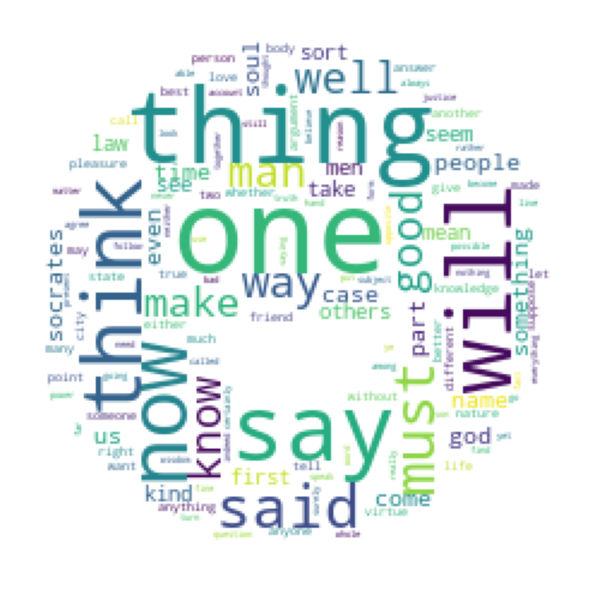

In [142]:
df1 = df[df.school=='plato']
text = " ".join(txt for txt in df1.sentence_lowered)
mask = np.array(Image.open('face.png'))
wordcloud = WordCloud(width = 600, height = 400,
                background_color ='white',
                max_font_size = 50,mask=mask).generate(text)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

We also created Violin plots for sentence lengths against each school of philosophy. Violin plots are a hybrid of box plots which show the peaks in the data and are used to visualise numerical data.
For example, consider the school of philosophy 'Aristotle', we observe that there are wider sections at the centre indicating that the sentence lengths of the school aristotle are highly concentrated around the median. 

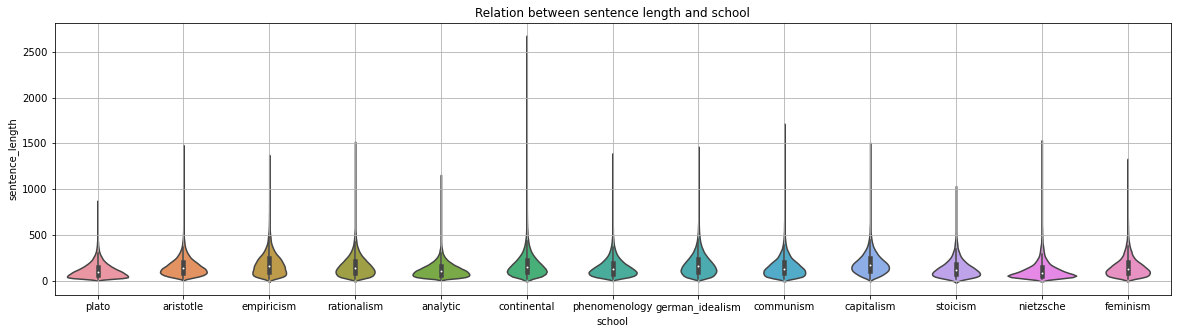

In [23]:
plt.figure(figsize=(20,5))
sns.violinplot(x="school", y="sentence_length", data=df)
plt.title("Relation between sentence length and school")
plt.grid()

# Data Cleaning 

Considering the sentences with respect to each school of philosophy, we start the data cleaning of the column 'sentence_lowered' in the data set. Tokenization is the first step in text mining which splits the input text into small structures called tokens. For this, 'spacy' library is used.  It first parses the text and generates tokens.  

In [143]:
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens
for i in df.sentence_lowered:
    (tokenize(i))

Then we use lemmatization to generate lemmas of each token above. Lemmas are the meaningful words derived from the original word. It removes the suffix of the word and converts it into its root meaning. for this we use 'wordnet' from nltk and input the word into an inbuilt method 'WordNetLemmatizer'.

In [144]:
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shriyanallamaddi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


One more important step in cleaning the text data is to remove the stop words which are basically pronouns, articles and the other most common words in English language. They add no meaning to the text analysis because of which they need to be removed.

In [145]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shriyanallamaddi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [146]:
#Function to implement tokenization, lemmatization and removing stop words
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

# Analysis

The main objective of this analysis is to identify which topics are mostly discussed pertaining to each school of philosophy. For this, we implemented the most commonly used topic modelling algorithm named 'Latent Dirichlet Allocation (LDA)'. We use this algorithm to convert the set of words into topics. Each topic is represented as the distribution of words. 
After converting the data ready to use for LDA algorithm, we create a dictonary from the data and convert to bag-of-words corpus.
We set the number of topics to 5 so that it gives five topics in the data for each school of philosophy. 
Along with the topics, it also gives a weightage to each word in the topic from which we can elaborate which word has the highest probability to belong to that particular topic. 

In [147]:
li = df.school.unique().tolist()
for a in li:
    df1 = df[df.school==a]
    text_data = []
    for i in df1.sentence_lowered:
        tokens = prepare_text_for_lda(i)
        text_data.append(tokens)
        

    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]

    pickle.dump(corpus, open('corpus.pkl', 'wb'))
    dictionary.save('dictionary.gensim')

    NUM_TOPICS = 5
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
    ldamodel.save('model5.gensim')
    topics = ldamodel.print_topics(num_words=4)
    

We used 'pyLDAvis' package to visualise the topics distribution. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.

In [134]:
#visualisation sample for the 'plato' school of philosophy
df1 = df[df.school=='plato']
text_data = []
for i in df1.sentence_lowered:
        tokens = prepare_text_for_lda(i)
        text_data.append(tokens)
#     
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)

dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
lda_display = gensimvis.prepare(lda, corpus, dictionary, sort_topics=False,mds='mmds')
pyLDAvis.display(lda_display)



/Users/shriyanallamaddi/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/shriyanallamaddi/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shriyanallamaddi/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shriyanallamaddi/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reloa

# Conclusion

Topic modelling can be used in many scenarios where we are to segertate data into different topics. In this analysis, we were able to predcit five topics for each school of philosophy which gives us an idea about what topics is each school mostly concrened about. 